# **Language Detection Model**


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import random

In [48]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/GSSoC 2025/Language Detection.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Improvement 1: Dataset Exploration & Cleaning**

**Isuue :** I noticed that in the provided Colab notebook, the dataset was uncleaned, which gave ~98% accuracy with  Naive Bayes.

**Objective:**


*   The goal of this step is to carefully understand the dataset, identify and remove any missing, duplicate, or invalid records, and perform text cleaning so that the data is properly structured and ready for model training.
*   This ensures that the model receives high-quality, consistent, and noise-free data, which helps improve its accuracy and overall performance.


**Benefits of this improvement:**



*  **Cleaner Input:** Special characters, numbers, and unwanted noise removed.
*  **No Data Leakage:** Duplicates removed so that same text doesn't appear in both train/test.
*  **Consistent Format:** Lowercasing ensures that Nature and nature are treated as the same word.
*  **Balanced Understanding:** Class distribution analysis helps in knowing if dataset is imbalanced (important for model choice).
*  **Ready for Vectorization:** Clean, normalized text is easier to process for TfidfVectorizer or any NLP model.



After performing proper data cleaning (removing noise, duplicates, and inconsistencies), the Naive Bayes accuracy is now ~94%.

While the accuracy slightly dropped, the model is now trained on cleaner data, which should improve its generalization ability and reduce overfitting. I have kept both versions for comparison in the README.







In [49]:
# Dataset structure check
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
df.head()

Columns: ['Text', 'Language']
Shape: (10337, 2)


,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [50]:
# Missing values, empty strings, duplicates
print("Missing per column:")
print(df.isnull().sum())
print("\nEmpty strings per column:")
print((df.values == '').sum(axis=0))
print("\nDuplicate rows count:", df.duplicated().sum())

Missing per column:
Text        0
Language    0
dtype: int64

Empty strings per column:
[0 0]

Duplicate rows count: 66


In [51]:
# Dropping duplicates
df = df.drop_duplicates()

In [52]:
# Unique languages
print("Unique Languages:", df['Language'].unique())

Unique Languages: ['English' 'Malayalam' 'Hindi' 'Tamil' 'Portugeese' 'French' 'Dutch'
 'Spanish' 'Greek' 'Russian' 'Danish' 'Italian' 'Turkish' 'Sweedish'
 'Arabic' 'German' 'Kannada']


In [53]:
# Class distribution
print("Counts per language:")
lang_counts = df['Language'].value_counts()
print(lang_counts)
# 17 different languages with varying sample counts (English most frequent, Hindi least)

Counts per language:
Language
English       1382
French        1007
Spanish        816
Portugeese     736
Italian        694
Russian        688
Sweedish       673
Malayalam      591
Dutch          542
Arabic         532
Turkish        471
German         465
Tamil          464
Danish         424
Kannada        366
Greek          358
Hindi           62
Name: count, dtype: int64


In [54]:
# Separating Features and Target Variable
X = df['Text']
y = df['Language']

In [55]:
# Label encoding - Converted language names to numeric labels for ML models
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['Arabic', 'Danish', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Hindi', 'Italian', 'Kannada', 'Malayalam', 'Portugeese',
       'Russian', 'Spanish', 'Sweedish', 'Tamil', 'Turkish'], dtype=object)

In [56]:
# Text cleaning (Regex + Lowercasing) - Removed numbers, punctuation, and converted all text to lowercase for consistency.
import re
processed_list = []
for content in X:
       # removing the symbols and numbers using regex
        content = re.sub(r'[!@#$().,"%^*?:;~`0-9]', ' ', content)
        content = re.sub(r'\[', ' ', content)
        content = re.sub(r'\]', ' ', content)
        content=content.strip()
        content = content.lower()
        processed_list.append(content)

processed_list[0:2]

['nature  in the broadest sense  is the natural  physical  material world or universe',
 'nature  can refer to the phenomena of the physical world  and also to life in general']

### **Improvement 2 : Language-wise Data Distribution Visualization**

**Objective:**


*  To visually analyze the dataset and understand how many samples are available for each language.

*  This helps in detecting class imbalance issues and ensures we have a clear picture of data distribution before training the model.


**Benefits of this improvement:**

*  **Identifies Class Imbalance:** If some languages have very few samples compared to others, we can take corrective steps (e.g., oversampling/undersampling).
*  **Better Model Planning:** Knowing the distribution helps in choosing suitable evaluation metrics (like weighted F1-score instead of just accuracy).
*  **Improves Data Understanding:** Makes it easier to explain dataset composition to others (mentors, teammates, stakeholders).


/tmp/ipython-input-3922912032.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lang_counts.index, y=lang_counts.values, palette="viridis")


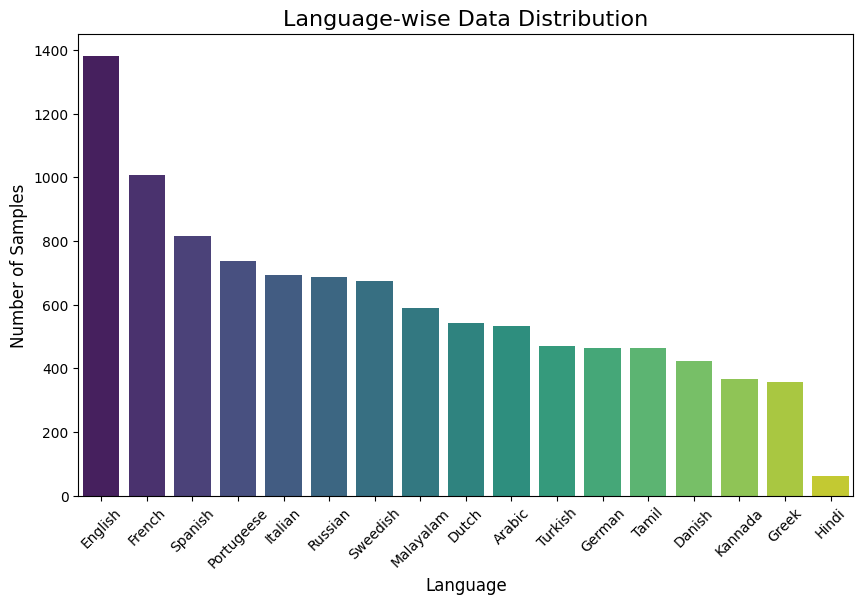

In [57]:
# Created a bar plot using Seaborn to visually represent the distribution.
plt.figure(figsize=(10,6))
sns.barplot(x=lang_counts.index, y=lang_counts.values, palette="viridis")
plt.title("Language-wise Data Distribution", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)
plt.show()

####  **Improvement 3: Replacing manual count vectorization with  TfidfVectorizer**


**Objective:**

* To improve text feature representation by replacing the basic Count Vectorization method with TF-IDF (Term Frequency–Inverse Document Frequency), which gives higher importance to unique and meaningful words while reducing the weight of very common words.

**Benefits of this improvement:**

*  **Better Feature Weighting:** Unlike Count Vectorization (which only counts word occurrences), TF-IDF also considers how rare or common a word is across all documents.
*  **Reduces Noise:** Words like "the", "is", "and" get less weight since they appear in many documents and carry less discriminative power..
*  **Improved Accuracy:** More meaningful word weights can lead to better model performance, especially in NLP tasks like language detection.



In [58]:
vectorizer = TfidfVectorizer()

# Transforming processed text list into TF-IDF vectors
X = vectorizer.fit_transform(processed_list).toarray()

print("TF-IDF Vector Shape:", X.shape)


TF-IDF Vector Shape: (10271, 39404)


In [59]:
np.random.seed(42)
random.seed(42)

### **Splitting the Dataset into Training and Testing Sets**

In [60]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

####  **Using Multinomial Naive Bayes for classification**

In [61]:
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

MultinomialNB()

In [62]:
nb_pred = nb_model.predict(x_test)

#### **Evaluation of the Naive bayes model**

In [63]:
nb_acc = accuracy_score(y_test, nb_pred)
nb_prec = precision_score(y_test, nb_pred, average='weighted', zero_division=0)
nb_rec = recall_score(y_test, nb_pred, average='weighted', zero_division=0)

print("Naive Bayes Results:")
print(f"Accuracy: {nb_acc * 100:.2f}%")
print(f"Precision: {nb_prec * 100:.2f}%")
print(f"Recall: {nb_rec * 100:.2f}%\n")

Naive Bayes Results:
Accuracy: 94.84%
Precision: 95.86%
Recall: 94.84%



#### **Improvement 4: Added multiple classifiers for performance comparison**

**Objective:**

* To evaluate multiple machine learning classifiers on the same dataset to identify which model performs best for language detection, ensuring that the chosen model provides the highest accuracy and reliability.

**Benefits of this improvement:**

*  **Objective model comparison :** avoids relying on a single algorithm.
*  **Performance transparency :** all metrics are visible for decision-making.
* Identified best model for deployment.
*  **Better generalization :** by testing multiple algorithms, we ensure the chosen model is less likely to fail in unseen scenarios.


**Steps Taken**
1. Selected multiple classifiers for evaluation:

*  Logistic Regression
*  Random Forest
*  Decision Tree
*  SVM



(Along with previously implemented Naive Bayes)

2. Trained each classifier using the same training dataset (x_train, y_train).
3. Evaluated performance of each model using:
*   Accuracy (overall correctness)
*   Precision (correctness for each predicted class)
*   Recall (ability to find all correct examples)


## **Issue faced**
Attempted to implement **SVM classifier** for this dataset.

However, due to frequent Colab runtime disconnections and high computation time,
the model could not be executed successfully.

**Therefore, SVM results are not included in the comparison.**





















In [64]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier()
}


#### **Logistic Regression**

In [65]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(x_train, y_train)
log_pred = log_model.predict(x_test)

In [66]:
log_acc = accuracy_score(y_test, log_pred)
log_prec = precision_score(y_test, log_pred, average='weighted', zero_division=0)
log_rec = recall_score(y_test, log_pred, average='weighted', zero_division=0)

print("Logistic Regression Results:")
print(f"Accuracy: {log_acc * 100:.2f}%")
print(f"Precision: {log_prec * 100:.2f}%")
print(f"Recall: {log_rec * 100:.2f}%\n")

Logistic Regression Results:
Accuracy: 94.68%
Precision: 96.32%
Recall: 94.68%



#### **Random forest**

In [67]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

In [68]:
rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred, average='weighted', zero_division=0)
rf_rec = recall_score(y_test, rf_pred, average='weighted', zero_division=0)

print("Random Forest Results:")
print(f"Accuracy: {rf_acc * 100:.2f}%")
print(f"Precision: {rf_prec * 100:.2f}%")
print(f"Recall: {rf_rec * 100:.2f}%\n")

Random Forest Results:
Accuracy: 92.44%
Precision: 95.62%
Recall: 92.44%



#### **Decision tree**

In [69]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_test)

In [70]:
dt_acc = accuracy_score(y_test, dt_pred)
dt_prec = precision_score(y_test, dt_pred, average='weighted', zero_division=0)
dt_rec = recall_score(y_test, dt_pred, average='weighted', zero_division=0)

print("Decision Tree Results:")
print("Accuracy:", round(dt_acc*100, 2), "%")
print("Precision:", round(dt_prec*100, 2), "%")
print("Recall:", round(dt_rec*100, 2), "%")

Decision Tree Results:
Accuracy: 86.44 %
Precision: 91.29 %
Recall: 86.44 %


In [71]:
# Stored results in a DataFrame for easy comparison.
results = []

results.append(['Naive Bayes', nb_acc, nb_prec, nb_rec])
results.append(['Logistic Regression', log_acc, log_prec, log_rec])
results.append(['Random Forest', rf_acc, rf_prec, rf_rec])
results.append(['Decision Tree', dt_acc, dt_prec, dt_rec])

In [72]:
# Sorted models by accuracy to find the best-performing algorithm.

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall'])

# Converting metrics to percentage format for readability
results_df[['Accuracy', 'Precision', 'Recall']] = results_df[['Accuracy', 'Precision', 'Recall']] * 100
results_df = results_df.round(2)

# Sort by Accuracy
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("Model Comparison Table:")
results_df.reset_index(drop=True, inplace=True)
display(results_df)


Model Comparison Table:


,Model,Accuracy,Precision,Recall
0,Naive Bayes,94.84,95.86,94.84
1,Logistic Regression,94.68,96.32,94.68
2,Random Forest,92.44,95.62,92.44
3,Decision Tree,86.44,91.29,86.44


/tmp/ipython-input-1839862490.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1839862490.py:5: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


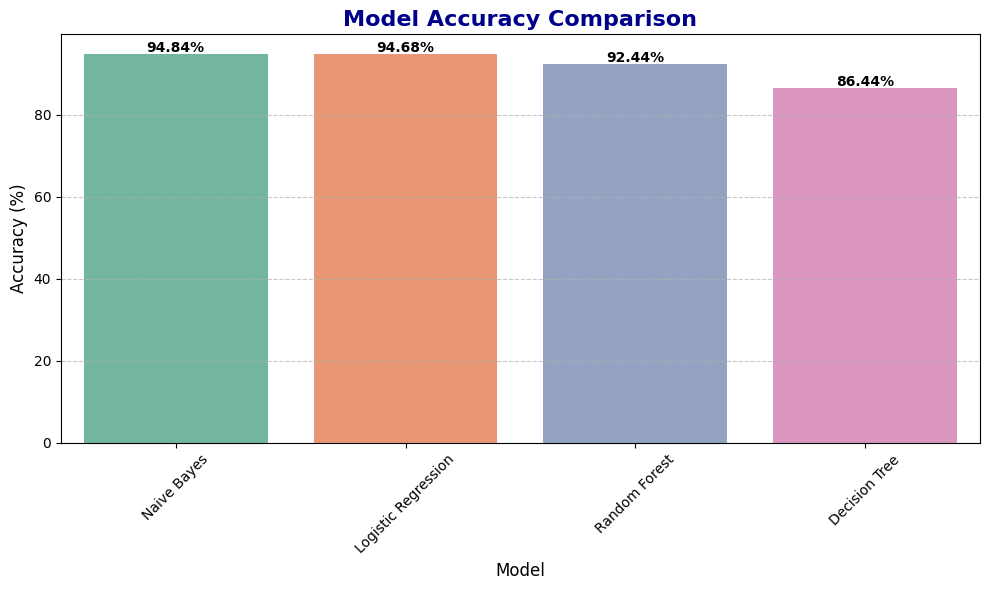

In [73]:
# Visualized the results using a bar plot to quickly see which model has the highest accuracy.
plt.figure(figsize=(10,6))
colors = sns.color_palette("Set2")

sns.barplot(
    data=results_df,
    x='Model',
    y='Accuracy',
    palette=colors
)

plt.title("Model Accuracy Comparison", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# Showing accuracy value on each bar
for index, row in results_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.5, f"{row['Accuracy']:.2f}%", ha='center', fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [74]:
print("Best model based on accuracy is:", results_df.iloc[0]['Model'])

Best model based on accuracy is: Naive Bayes


#### **Improvemnet 5 : Adding Confusion Matrix Heatmap for Each Classifier**

**Objective:**

* To visualize the classification performance of each model by showing the distribution of correct and incorrect predictions for each language. This helps in identifying where the model is making mistakes and which classes are being confused with each other.

**Benefits of this improvement:**

* **Detailed Error Analysis:** Shows exactly which languages are getting misclassified into which categories.
*  **Better Model Understanding:** Helps compare the strengths and weaknesses of different classifiers beyond just accuracy, precision, and recall.
* **Visual Insight:** Makes it easier to communicate model performance to non-technical stakeholders.
* **Model Selection Support:** Can help decide which classifier to use for deployment by revealing systematic misclassifications.

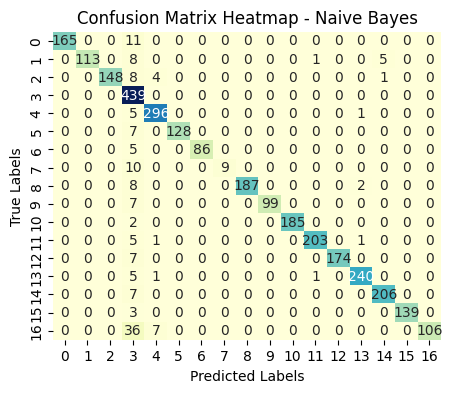

In [76]:
# Naive Bayes Confusion Matrix Heatmap
cm = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrix Heatmap - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

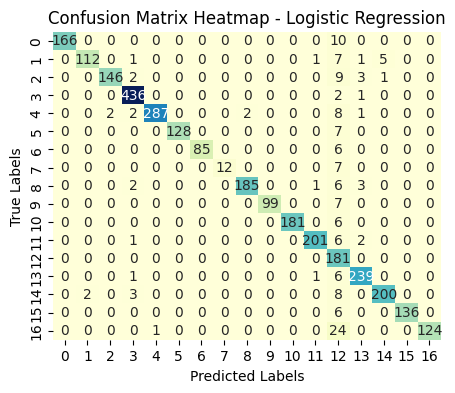

In [77]:
# Logistic Regression Confusion Matrix Heatmap
cm = confusion_matrix(y_test, log_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrix Heatmap - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

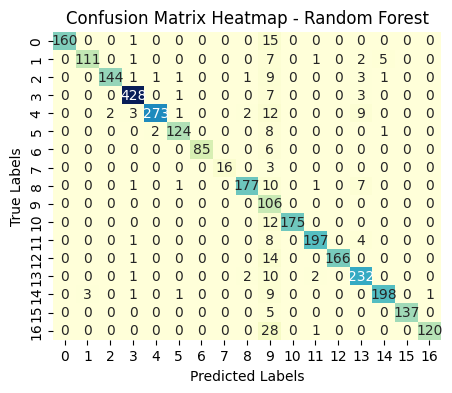

In [78]:
# Random Forest Confusion Matrix Heatmap
cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrix Heatmap - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

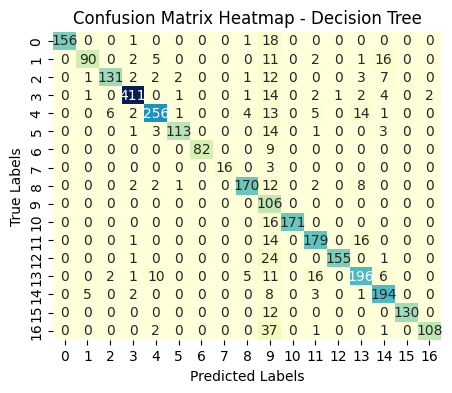

In [79]:
# Decision Tree Confusion Matrix Heatmap
cm = confusion_matrix(y_test, dt_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrix Heatmap - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [80]:
# Sample Prediction Check (Actual vs Predicted)
print("Test Content (Count Vector of the content) : ",x_test[0])
print("Predicted label(Encoded) : ",nb_pred[0])
print("Actual Label (Encoded) : ",y_test[0])

Test Content (Count Vector of the content) :  [0. 0. 0. ... 0. 0. 0.]
Predicted label(Encoded) :  16
Actual Label (Encoded) :  16
